In [54]:
## Pyro GP tutorial used as starting point:
## https://pyro.ai/examples/gp.html

import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as pdist
import arviz

# Partition observations
X = np.asarray([x / 29 for x in range(1, 31)])
np.random.shuffle(X)
Y = 6 * np.square(X) - np.square(np.sin(6 * np.pi * X)) - 5 * np.power(X, 4) + 3 / 2 + np.random.normal(0.0, 0.01, 30)
Xtrain, Xtest, Ytrain, Ytest = torch.tensor(X[10:]), torch.tensor(X[:10]), torch.tensor(Y[10:]), torch.tensor(Y[:10])

### Selecting a suitable model

In [57]:
# We chose a GP regression model and the Matern 3/2 kernel. In this setup, we have three hyper-parameters.
# I) The variance of the kernel, II) the lengthscale of the kernel, and III) the gaussian noise of the model.
# We chose to let the gaussian noise be fixed and equal to the noise of our data, while keeping the variance
# and lengthscale of the kernel variable. The prior distrubition we chose is a multivariate normal
# distribution (i.e. we consider the variance and lengthscale as normally distributed), with mean and variance
# based on what seems reasonable for the Matern 3/2 kernel, based on the lecture slides.

# Define model
class GPModel:
    def __init__(self, kernel):
        self.kernel = kernel

    def __call__(self, xs, ys=None):
        self.kernel.lengthscale = pyro.sample("lengthscale", pdist.LogNormal(0.0, 1.0))
        self.kernel.variance = pyro.sample("variance", pdist.LogNormal(0.0, 1.0))
        gp_model =  gp.models.GPRegression(xs, ys, self.kernel, noise=torch.tensor(0.01))
        return gp_model.model()

    

prior = 0
# Computes log-likelihood
def logLikelihood(xs, ys, theta=prior):
    # solution based on lecture notes section 6.3
    kernel = gp.kernels.Matern32(input_dim=1, variance=theta[0], lengthscale=theta[1])
    t1 = 0.5 * torch.transpose(ys, 0, 0) * torch.linalg.inv(kernel.forward(xs)) * ys
    t2 = 0.5 * torch.log(torch.linalg.det(kernel.forward(xs)))
    t3 = 15.0 * torch.log(2 * torch.tensor(np.pi))
    return - t1 - t2 - t3

### Using NUTS

In [65]:
# Model is GP model from pyro
W = 100 # Number of warmup steps
C = 1 # Number of chains
S = 100 # Number of samples used in prediction
pyro.clear_param_store()
gp_kernel = gp.kernels.RBF(input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(1))
# gp_model_nuts = model(Xtrain, Ytrain)
# guide = pyro.infer.autoguide.AutoDelta(model)

nuts_kernel = pyro.infer.NUTS(GPModel(gp_kernel), jit_compile=False)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=S, num_chains=C, warmup_steps=W)
mcmc.run(Xtrain, Ytrain)

Sample: 100%|██████████| 200/200 [03:19,  1.00it/s, step size=2.90e-04, acc. prob=0.695]


#### Checking quality of samples using arviz

/Users/vic/Desktop/Computer Science/2/PML/Final Project/PMLFinalProject/venv/lib/python3.11/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)
Warmup:   2%|▏         | 10/600 [16:49, 100.91s/it, step size=2.43e-04, acc. prob=0.486]

{'lengthscale': tensor([0.0647, 0.0585, 0.0667, 0.0638, 0.0695, 0.0679, 0.0715, 0.0729, 0.0737,
        0.0712, 0.0698, 0.0728, 0.0689, 0.0700, 0.0774, 0.0740, 0.0743, 0.0726,
        0.0797, 0.0802, 0.0795, 0.0696, 0.0746, 0.0715, 0.0743, 0.0801, 0.0809,
        0.0795, 0.0793, 0.0738, 0.0772, 0.0729, 0.0813, 0.0823, 0.0832, 0.0785,
        0.0760, 0.0740, 0.0693, 0.0669, 0.0694, 0.0690, 0.0647, 0.0711, 0.0761,
        0.0713, 0.0788, 0.0727, 0.0698, 0.0759, 0.0829, 0.0726, 0.0686, 0.0720,
        0.0757, 0.0727, 0.0734, 0.0740, 0.0756, 0.0749, 0.0701, 0.0756, 0.0763,
        0.0765, 0.0718, 0.0734, 0.0749, 0.0716, 0.0719, 0.0719, 0.0802, 0.0726,
        0.0777, 0.0723, 0.0721, 0.0634, 0.0738, 0.0759, 0.0739, 0.0734, 0.0825,
        0.0830, 0.0755, 0.0774, 0.0804, 0.0817, 0.0819, 0.0681, 0.0657, 0.0622,
        0.0650, 0.0738, 0.0748, 0.0755, 0.0713, 0.0744, 0.0737, 0.0818, 0.0830,
        0.0823], dtype=torch.float64), 'variance': tensor([2.3544, 2.3188, 2.1998, 2.2005, 2.2532, 2.415

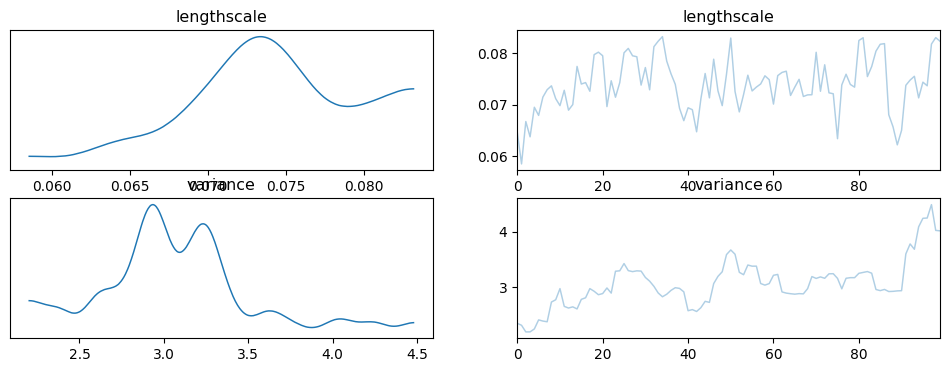

array([<Axes: title={'center': 'lengthscale'}>,
       <Axes: title={'center': 'variance'}>], dtype=object)

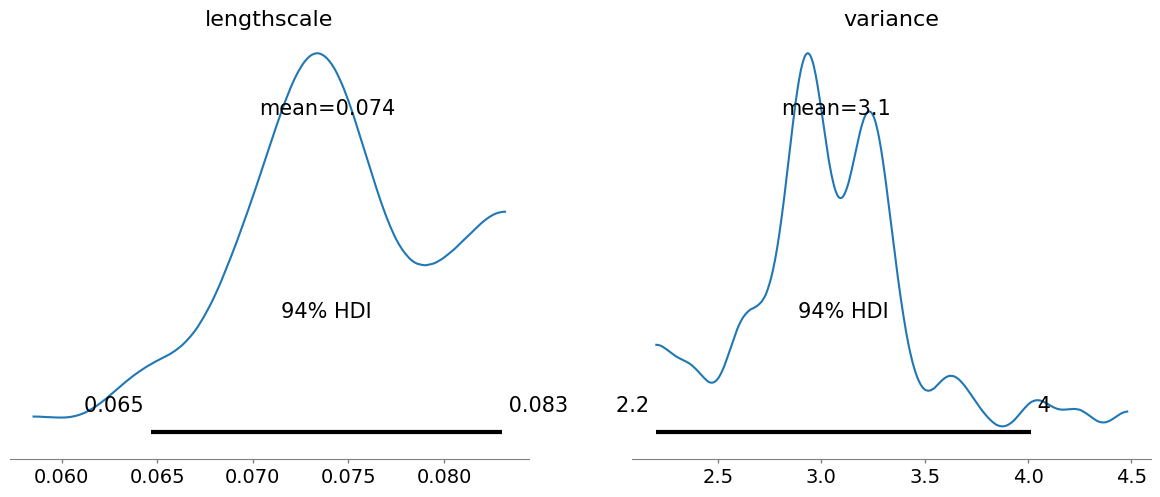

In [66]:
posterior_samples = mcmc.get_samples()
print(posterior_samples)
data = arviz.from_pyro(mcmc)
print(data)
summary = arviz.summary(data)
print(summary)
arviz.plot_trace(data)
plt.show()
# Maybe use this: arviz.rcParams['plot.max_subplots'] = 18
arviz.plot_posterior(data) # TODO: Change var names